In [ ]:
import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import InceptionV3
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')

Modules loaded


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
dataset_path = "/content/drive/MyDrive/Colab Notebooks/content/dataset_of_lung_cancer"
filepaths = []
labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            filepaths.append(file_path)
            labels.append(class_name)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Split 80%, 10%, 10%
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Data normalization for validation and test
valid_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

batch_size = 12

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),  # InceptionV3 input size
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),  # InceptionV3 input size
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),  # InceptionV3 input size
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1658 validated image filenames belonging to 3 classes.
Found 207 validated image filenames belonging to 3 classes.
Found 208 validated image filenames belonging to 3 classes.


In [ ]:
# Model Structure
class_count = len(train_gen.class_indices)
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l=0.016),
          activity_regularizer=tf.keras.regularizers.l1(0.006),
          bias_regularizer=tf.keras.regularizers.l1(0.006),
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

In [ ]:
epochs = 30
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=valid_gen,
    validation_steps=len(valid_gen),
    epochs=epochs
)

Epoch 1/30
139/139 [==============================] - 928s 6s/step - loss: 8.7162 - accuracy: 0.7419 - val_loss: 8.2494 - val_accuracy: 0.7923
Epoch 2/30
139/139 [==============================] - 877s 6s/step - loss: 8.2632 - accuracy: 0.8908 - val_loss: 8.0679 - val_accuracy: 0.9130
Epoch 3/30
139/139 [==============================] - 883s 6s/step - loss: 8.1005 - accuracy: 0.9210 - val_loss: 8.0273 - val_accuracy: 0.9662
Epoch 4/30
139/139 [==============================] - 862s 6s/step - loss: 7.9552 - accuracy: 0.9252 - val_loss: 7.9864 - val_accuracy: 0.9420
Epoch 5/30
139/139 [==============================] - 875s 6s/step - loss: 7.7848 - accuracy: 0.9433 - val_loss: 7.7977 - val_accuracy: 0.9565
Epoch 6/30
139/139 [==============================] - 858s 6s/step - loss: 7.6218 - accuracy: 0.9457 - val_loss: 7.6301 - val_accuracy: 0.9662
Epoch 7/30
139/139 [==============================] - 873s 6s/step - loss: 7.4534 - accuracy: 0.9602 - val_loss: 7.4735 - val_accuracy: 0.9710

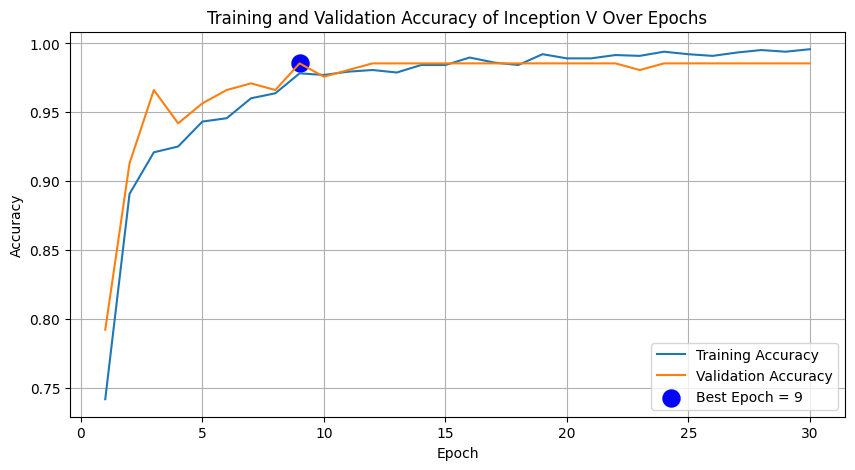

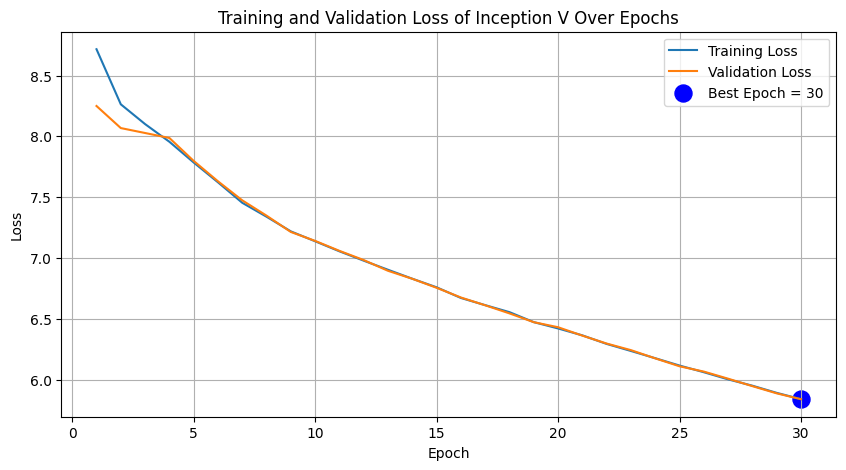

In [ ]:
import os
import matplotlib.pyplot as plt

tr_loss = history.history['loss']
tr_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

epochs = range(1, len(tr_loss) + 1)
loss_label = f'Best Epoch = {index_loss + 1}'
acc_label = f'Best Epoch = {index_acc + 1}'

#accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, tr_acc, label='Training Accuracy', linestyle='-')
plt.plot(epochs, val_acc, label='Validation Accuracy', linestyle='-')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy of Inception V Over Epochs')
plt.grid(True)
plt.show()

#loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, tr_loss, label='Training Loss', linestyle='-')
plt.plot(epochs, val_loss, label='Validation Loss', linestyle='-')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss of Inception V Over Epochs')
plt.grid(True)
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

4/4 [==============================] - 7s 2s/step - loss: 5.8263 - accuracy: 1.0000
Train Loss:  5.78134298324585
Train Accuracy:  1.0
--------------------
Validation Loss:  5.805248260498047
Validation Accuracy:  1.0
--------------------
Test Loss:  5.826273441314697
Test Accuracy:  1.0


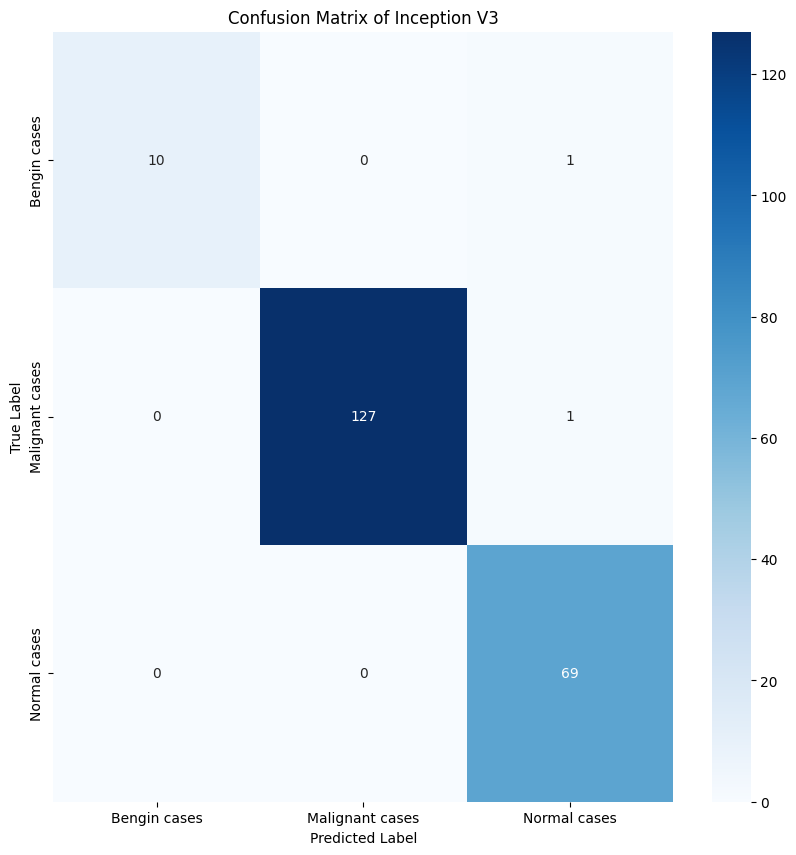

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Inception V3')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                 precision    recall  f1-score   support

   Bengin cases       1.00      0.91      0.95        11
Malignant cases       1.00      0.99      1.00       128
   Normal cases       0.97      1.00      0.99        69

       accuracy                           0.99       208
      macro avg       0.99      0.97      0.98       208
   weighted avg       0.99      0.99      0.99       208

